In [1]:
import logging
import os
from datetime import timedelta
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xarray as xr

# prompt: Find gefs data , use this information https://nomads.ncep.noaa.gov/pub/data/nccf/com/gens/prod/gefs.20250530/.. download the data before trying to access it

# We need to construct the URL for the desired data.
# The pattern seems to be: https://nomads.ncep.noaa.gov/pub/data/nccf/com/gens/prod/gefs.YYYYMMDD/
# We also need to specify the ensemble member and the forecast hour.
# The specific file names are also structured, e.g., gefs.t00z.pgrb2a.0p50.f006.grib2
# where t00z is the cycle time (00Z), pgrb2a is the grid type, 0p50 is the resolution.

now = pd.Timestamp.now()
start = now - timedelta(hours=54)
end = now - timedelta(hours=6)
time_range = pd.date_range(
    start.floor("24h"), end.floor("24h"), freq="24h"
)  # round down to nearest multiple

In [3]:
shortName, isobaricInhPa = "t", 850


def build_file_url(init_time, mem, forecast_hour):
    return (
        f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/gens/prod/gefs.{init_time:%Y%m%d}/"
        f"{init_time:%H}/atmos/pgrb2ap5/"
        f"{mem}.t{init_time:%H}z.pgrb2a.0p50.f{forecast_hour:03d}"
    )


def local_path_from_url(gfsdir, file_url_str):
    url_path = Path(file_url_str)
    file_path = gfsdir.joinpath(*url_path.parts[-5:])
    os.makedirs(file_path.parent, exist_ok=True)
    return file_path


def open_grib_dataset(path):
    return xr.open_dataset(
        path,
        engine="cfgrib",
        backend_kwargs={"errors": "ignore"},
        filter_by_keys={
            "typeOfLevel": "isobaricInhPa",
            "level": isobaricInhPa,
            "shortName": shortName,
        },
        decode_timedelta=True,
        chunks={},  # chunking can help reduce memory usage
    )


def download_file(url, local_file_path):
    try:
        response = requests.get(url, stream=True, timeout=30)
        response.raise_for_status()
        with open(local_file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Successfully downloaded: {local_file_path}")
    except requests.exceptions.RequestException as e:
        print(f"Error during download: {e}")
        print(f"Could not download {url}")
        print("Please verify the date of the file exists on the server.")

In [4]:
def pangu_ifiles(pangu_dir, init_time, mem):
    file_path = pangu_dir / init_time.strftime("%Y%m%d%H") / f"ens{mem}" / "pangu_forecast_data"
    ifiles = [file_path / f"pangu_ens{mem}_pred_{i:03d}.nc" for i in range(12, 241, 12)]
    return ifiles


def add_ensemble_number(ds):
    """
    A preprocessing function to be used with xr.open_mfdataset.
    It extracts the ensemble member number from the source filename
    and adds it as a 'number' coordinate.
    """
    # Get the basename of the file (e.g., "pangu_ens0_pred_162.nc")
    try:
        filename = os.path.basename(ds.encoding["source"])
    except (KeyError, TypeError):
        # Fallback if source encoding is not available
        return ds

    # Use a regular expression to find the number following 'ens'
    match = re.search(r'ens(\d+)', filename)

    if match:
        # Extract the number, convert to integer
        ensemble_number = int(match.group(1))

        # Add 'number' as a new dimension and assign the extracted number as its coordinate
        return ds.expand_dims(number=[ensemble_number])

    return ds


In [5]:
pangu_dir = Path("/glade/derecho/scratch/sobash/pangu_realtime")
# Create a nested list where list[init_time][member] = [files_for_all_forecast_hours]
nested_files = []
for init_time in time_range:
    # List for all members for this init_time
    time_specific_files = []
    for mem in range(51):
        # List of all forecast hour files for this specific member
        member_files = pangu_ifiles(pangu_dir, init_time, mem)
        time_specific_files.append(member_files)

    # Only add the list of time-specific files if it's not empty
    if time_specific_files:
        nested_files.append(time_specific_files)

# The channel label we want to select
channel_label = f"{shortName}{isobaricInhPa}"

# A single, chained pipeline to process the data
ds_pangu = (
    xr.open_mfdataset(
        nested_files,
        combine="nested",
        concat_dim=["init_time", "number", "prediction_timedelta"],
        chunks="auto",  # Use 'auto' for better performance with dask
    )
    # Rename dimensions and coordinates at the start
    .rename(
        {
            "init_time": "initialization_time",
            "prediction_timedelta": "step",
            "lat": "latitude",
            "lon": "longitude",
            "__xarray_dataarray_variable__": shortName,  # Rename the main variable
        }
    )
    # Assign the integer coordinate for the 'number' dimension
    .assign_coords(number=range(51))
    # Convert 'step' dimension from timedelta to integer forecast hours
    .pipe(
        lambda ds: ds.assign_coords(
            forecast_hour=("step", ds["step"].data / np.timedelta64(1, "h"))
        ).swap_dims({"step": "forecast_hour"})
    )
    # Calculate the valid_time coordinate
    .assign(valid_time=lambda ds: ds.initialization_time + ds.step)
    # Select the desired channel by its label (more readable)
    .sel(channel=channel_label)
    # Add the pressure level as a non-dimension coordinate
    .assign_coords(isobaricInhPa=isobaricInhPa)
)

ds_pangu

<xarray.Dataset> Size: 633MB
Dimensions:              (number: 51, initialization_time: 3,
                          forecast_hour: 20, latitude: 161, longitude: 321)
Coordinates:
  * initialization_time  (initialization_time) datetime64[ns] 24B 2025-06-11 ...
    step                 (forecast_hour) timedelta64[ns] 160B 0 days 12:00:00...
    channel              <U5 20B 't850'
  * latitude             (latitude) float64 1kB 60.0 59.75 59.5 ... 20.25 20.0
  * longitude            (longitude) float64 3kB 220.0 220.2 ... 299.8 300.0
  * number               (number) int64 408B 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
  * forecast_hour        (forecast_hour) float64 160B 12.0 24.0 ... 228.0 240.0
    isobaricInhPa        int64 8B 850
Data variables:
    t                    (number, initialization_time, forecast_hour, latitude, longitude) float32 633MB dask.array<chunksize=(1, 1, 1, 161, 321), meta=np.ndarray>
    valid_time           (initialization_time, forecast_hour) datetime64[ns] 480B ...

In [6]:
gfs_ensemble_member = ["gec00"] + [f"gep{i:02d}" for i in range(1, 31)]
gfsdir = Path(os.getenv("TMPDIR")) / "gefs"
datasets = []
for init_time in time_range:
    for mem in gfs_ensemble_member:
        for forecast_hour in range(0, 241, 12):
            file_url = build_file_url(init_time, mem, forecast_hour)
            local_file_path = local_path_from_url(gfsdir, file_url)

            if not os.path.exists(local_file_path):
                print(f"Attempting to download: {file_url}")
                download_file(file_url, local_file_path)
            else:
                logging.info(f"{local_file_path} exists.")

            ds_gfs = open_grib_dataset(local_file_path)
            datasets.append(ds_gfs)

# Combine and process
ds_gfs = xr.combine_nested(datasets, concat_dim=["time"])

init_times = ds_gfs["valid_time"] - ds_gfs["step"]
ds_gfs = ds_gfs.assign_coords(initialization_time=init_times)
ds_gfs = ds_gfs.groupby(["initialization_time", "step", "number"]).first()

step_as_hours = ds_gfs["step"].data / pd.to_timedelta("1h")
ds_gfs = ds_gfs.assign_coords(forecast_hour=("step", step_as_hours))
ds_gfs = ds_gfs.swap_dims(step="forecast_hour")
ds_gfs["valid_time"] = ds_gfs.initialization_time + ds_gfs.step

ds_gfs

<xarray.Dataset> Size: 793MB
Dimensions:              (initialization_time: 3, forecast_hour: 21,
                          number: 31, latitude: 141, longitude: 720)
Coordinates:
  * initialization_time  (initialization_time) datetime64[ns] 24B 2025-06-10 ...
    step                 (forecast_hour) timedelta64[ns] 168B 0 days 00:00:00...
  * number               (number) int64 248B 0 1 2 3 4 5 6 ... 25 26 27 28 29 30
    isobaricInhPa        float64 8B 850.0
  * latitude             (latitude) float64 1kB 90.0 89.5 89.0 ... 20.5 20.0
  * longitude            (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
  * forecast_hour        (forecast_hour) float64 168B 0.0 12.0 ... 228.0 240.0
Data variables:
    t                    (latitude, longitude, initialization_time, forecast_hour, number) float32 793MB dask.array<chunksize=(141, 720, 1, 1, 1), meta=np.ndarray>
    valid_time           (initialization_time, forecast_hour) datetime64[ns] 504B ...

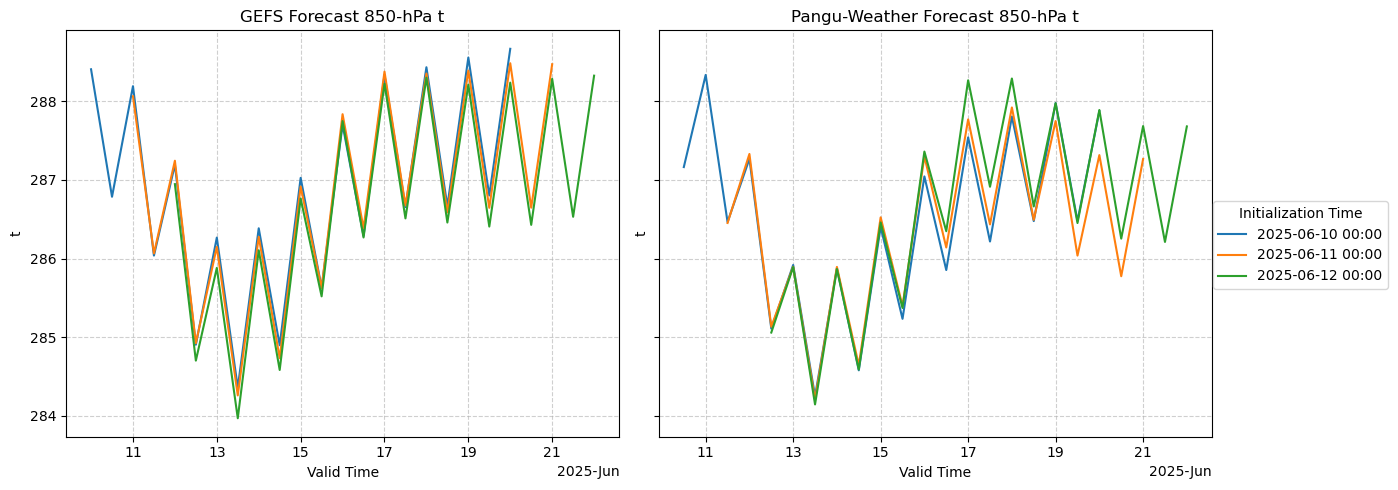

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=True)

# These will store the handles and labels for our shared legend
handles = []
labels = []

for ax, ds_model, title in zip(axes, [ds_gfs, ds_pangu], ["GEFS", "Pangu-Weather"]):
    # Geograpic subset
    ds_model = ds_model.sel(latitude=slice(60, 20)).sel(longitude=slice(220, 300))

    # --- Data processing steps (explained above) ---
    ensemble_mean = ds_model.mean(dim=["number", "latitude", "longitude"])

    # --- Data Reshaping (Stacking) ---
    # To prepare for plotting against 'valid_time', we first need to reshape the
    # data. `.stack()` combines the two dimensions into a single "MultiIndex"
    # dimension named 'point'. The data is now effectively a 1D series where
    # each data point is indexed by a (initialization_time, forecast_hour) pair.
    stacked_ds = ensemble_mean.stack(point=("initialization_time", "forecast_hour"))

    # --- Swapping the Index ---
    # This is a critical step. We replace the 'point' index with a new MultiIndex
    # composed of 'initialization_time' and 'valid_time'. This aligns each
    # data point with its specific start time and valid time, preparing it for the final pivot.
    tidy_ds = stacked_ds.set_index(point=["initialization_time", "valid_time"])

    # --- Final Pivot (Unstacking) ---
    # `.unstack()` performs the final pivot. It converts the data into the ideal 2D
    # "tidy" format for plotting:
    #   - Rows are indexed by 'valid_time' (our desired x-axis).
    #   - Columns are indexed by 'initialization_time' (our desired series/hues).
    plot_ready = tidy_ds[shortName].unstack("point").load()  # so I can print it below

    # --- Plotting ---
    plot_ready.plot.line(
        x="valid_time",
        hue="initialization_time",
        ax=ax,
        add_legend=False,
    )

    # --- Axis formatting ---
    ax.set_title(f"{title} Forecast {isobaricInhPa}-hPa {shortName}")
    ax.set_xlabel("Valid Time")
    ax.grid(True, linestyle="--", alpha=0.6)

    # --- Capture handles and create labels ONCE from the first plot ---
    if not handles:  # An empty list is False, so this runs only on the first iteration
        handles = ax.get_lines()
        # Create nicely formatted labels from the coordinate values
        labels = [
            pd.to_datetime(t).strftime("%Y-%m-%d %H:%M")
            for t in plot_ready.initialization_time.values
        ]

# Add a shared legend to the right of the figure
fig.legend(
    handles, labels, title="Initialization Time", loc="center right", bbox_to_anchor=(1.0, 0.5)
)

# Adjust layout to make room for the legend
fig.tight_layout(rect=[0, 0, 0.88, 1])  # Adjusted rect to give legend more space

In [13]:
plot_ready

<xarray.DataArray 't' (initialization_time: 3, valid_time: 24)> Size: 288B
array([[287.1635 , 288.33575, 286.4642 , 287.26852, 285.10913, 285.91885,
        284.24905, 285.87585, 284.5793 , 286.40292, 285.23398, 287.04495,
        285.8543 , 287.5414 , 286.21704, 287.80655, 286.47693, 287.97894,
        286.47906, 287.87476,       nan,       nan,       nan,       nan],
       [      nan,       nan, 286.45306, 287.3304 , 285.13354, 285.8963 ,
        284.20645, 285.89447, 284.6443 , 286.52448, 285.39746, 287.29712,
        286.14114, 287.76987, 286.43457, 287.9217 , 286.4923 , 287.749  ,
        286.0379 , 287.3161 , 285.77548, 287.26666,       nan,       nan],
       [      nan,       nan,       nan,       nan, 285.0596 , 285.89313,
        284.14594, 285.86786, 284.58896, 286.4592 , 285.37173, 287.36075,
        286.34778, 288.26746, 286.91306, 288.2897 , 286.6627 , 287.97565,
        286.45178, 287.88962, 286.25357, 287.68533, 286.21143, 287.68057]],
      dtype=float32)
Coordinates:
  * initialization_time  (initialization_time) datetime64[ns] 24B 2025-06-10 ...
  * valid_time           (valid_time) datetime64[ns] 192B 2025-06-10T12:00:00...
    step                 (initialization_time, valid_time) timedelta64[ns] 576B ...
    channel              <U5 20B 't850'
    isobaricInhPa        int64 8B 850
    forecast_hour        (initialization_time, valid_time) float64 576B 12.0 ...

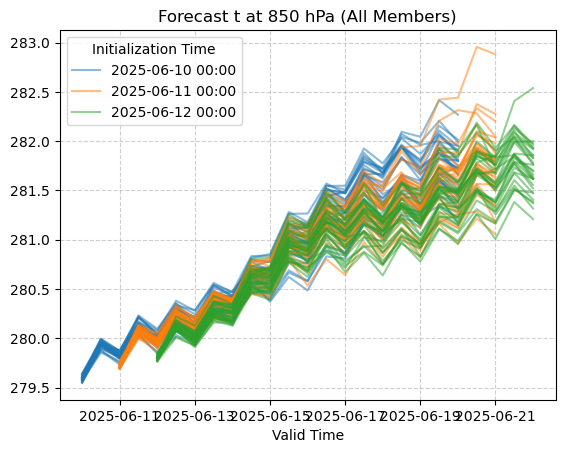

In [14]:
# 1. Select pressure level and average over spatial dimensions ONLY
# This keeps the 'number' dimension for the ensemble members.
ds_processed = ds_gfs.mean(dim=["latitude", "longitude"])

# 2. Create a plot figure and axes
fig, ax = plt.subplots()

# 3. Loop over each initialization time
for init_time in ds_processed.initialization_time:
    # Select all members for this single forecast run
    run_with_members = ds_processed.sel(initialization_time=init_time)

    # Plot the first member to establish the color and label for the legend
    first_member_data = run_with_members.isel(number=0)
    line = ax.plot(
        first_member_data.valid_time,
        first_member_data[shortName],
        alpha=0.5,
        label=pd.to_datetime(init_time.values).strftime("%Y-%m-%d %H:%M"),
    )
    # Get the color matplotlib automatically assigned to the first line
    run_color = line[0].get_color()

    # Loop over the REST of the members and plot them with the same color
    for member_index in range(1, len(run_with_members.number)):
        member_data = run_with_members.isel(number=member_index)
        ax.plot(
            member_data.valid_time,
            member_data[shortName],
            alpha=0.5,
            color=run_color,  # Reuse the color from the first member
        )

# --- Add labels and title for a publication-quality plot ---
ax.set_title(f"Forecast {shortName} at {isobaricInhPa} hPa (All Members)")
ax.set_xlabel("Valid Time")
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(title="Initialization Time")

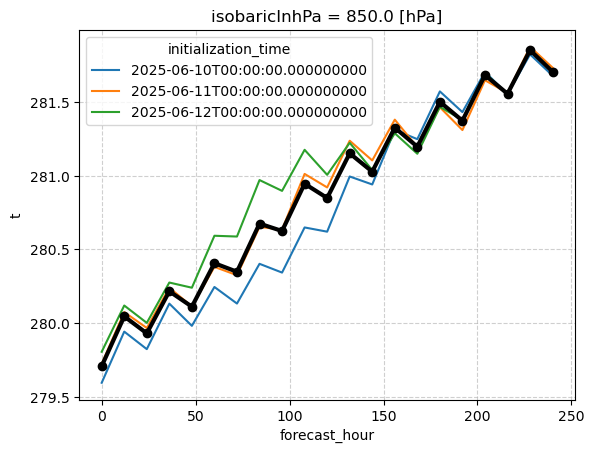

In [10]:
ensemble_mean = ds_gfs[shortName].mean(dim=["number", "latitude", "longitude"])
ensemble_mean.plot.line(x="forecast_hour", hue="initialization_time")
# TODO: Why different values when "initialization_time" included in prior mean() operation?
ensemble_mean.mean(dim="initialization_time").plot.line(
    x="forecast_hour", lw=3, c="k", label="mean", marker="o"
)
plt.grid(True, linestyle="--", alpha=0.6)

In [ ]:
# average over initialization_time, lat and lon. std over ensemble (number).
ensemble_spread = (
    ds_gfs[shortName].std(dim="number").mean(dim=["initialization_time", "latitude", "longitude"])
)


truth = ds_gfs.sel(forecast_hour=0, drop=True).mean(dim="number")  # remove forecast_hour coordinate

# error = ensemble mean - truth
error = ds_gfs.mean(dim="number") - truth
se = error[shortName] ** 2
mse = se.mean(dim=["initialization_time", "latitude", "longitude"])
rmse = np.sqrt(mse)
rmse.plot.line(x="forecast_hour", marker="o", label="rmse")
ensemble_spread.plot.line(x="forecast_hour", marker="o", label="spread")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()